Practial 12 : TensorFlow/Pytorch implementation of CNN

download dataset in data folder 
https://www.kaggle.com/datasets/janzenliu/cifar-10-batches-py

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [5]:
# Data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load cifar-10-batches-py dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 → 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 → 8x8
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100. * correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_losses.append(val_loss / len(test_loader))
    val_acc.append(100. * correct / total)

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")

Epoch 1: Train Loss: 1.5502, Train Acc: 43.52% | Val Loss: 1.1920, Val Acc: 56.73%
Epoch 2: Train Loss: 1.2424, Train Acc: 55.34% | Val Loss: 1.0364, Val Acc: 63.20%
Epoch 3: Train Loss: 1.1144, Train Acc: 60.23% | Val Loss: 0.9245, Val Acc: 67.18%
Epoch 4: Train Loss: 1.0289, Train Acc: 63.38% | Val Loss: 0.8687, Val Acc: 69.27%
Epoch 5: Train Loss: 0.9631, Train Acc: 65.79% | Val Loss: 0.8382, Val Acc: 70.62%
Epoch 6: Train Loss: 0.9177, Train Acc: 67.56% | Val Loss: 0.8027, Val Acc: 71.83%
Epoch 7: Train Loss: 0.8853, Train Acc: 68.99% | Val Loss: 0.7641, Val Acc: 73.58%
Epoch 8: Train Loss: 0.8576, Train Acc: 69.90% | Val Loss: 0.7743, Val Acc: 73.53%
Epoch 9: Train Loss: 0.8259, Train Acc: 70.91% | Val Loss: 0.7451, Val Acc: 73.93%
Epoch 10: Train Loss: 0.8062, Train Acc: 71.73% | Val Loss: 0.7217, Val Acc: 74.19%


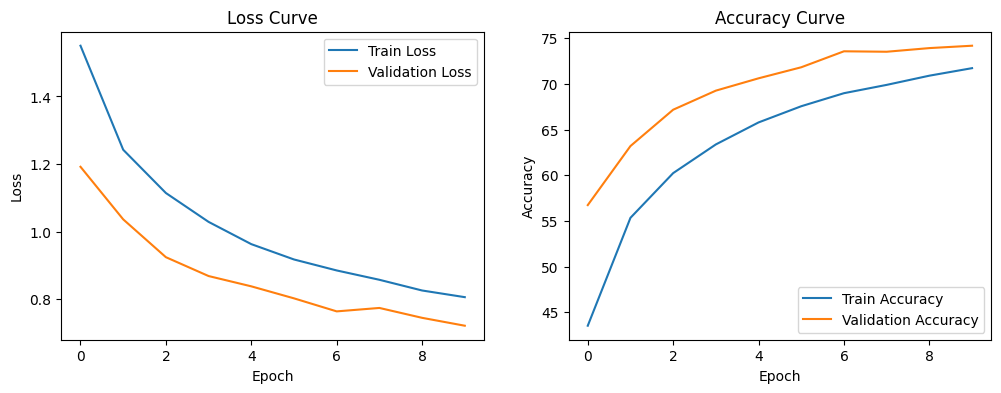

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

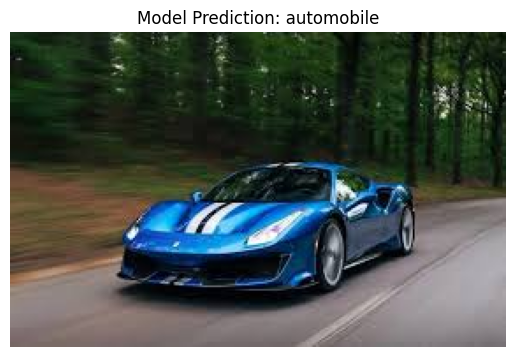

In [10]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define a transform similar to test set
user_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def predict_user_image(img_path, model):
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    input_tensor = user_transform(img).unsqueeze(0).to(device)

    # Model inference
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        pred_class = test_dataset.classes[predicted.item()]

    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Model Prediction: {pred_class}")
    plt.axis('off')
    plt.show()

predict_user_image("car.jpg", model)